### Import pyspark using Docker

In [1]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np

### Start Spark Session

In [2]:
spark = SparkSession.builder.appName('ML').getOrCreate()

### Load Data

In [3]:
df = spark.read.csv('train_set.csv', header = True).select('Text', 'verified')

In [4]:
### View data
df.show(10)

+--------------------+--------+
|                Text|verified|
+--------------------+--------+
|really happy evan...|    true|
|lived west guinea...|    true|
|excellent look co...|   false|
|anything challeng...|    true|
|great movie missi...|    true|
|movie english gre...|    true|
|fascinating true ...|    true|
|appears german en...|    true|
|movie english alt...|    true|
|sorry didnt purch...|    true|
+--------------------+--------+
only showing top 10 rows



In [5]:
#### look for nan values 
print('Null Text:', df.where((df["Text"].isNull())).count())
print('Null verified:', df.where((df["verified"].isNull())).count())

Null Text: 63987
Null verified: 0


In [6]:
### drop na's
df = df.na.drop()
df.count()

6942050

In [7]:
### create a Label column
df = df.withColumn('label', when(df.verified == 'true', 1.0).otherwise(0.0)).select('Text', 'label')
df.show(10)

+--------------------+-----+
|                Text|label|
+--------------------+-----+
|really happy evan...|  1.0|
|lived west guinea...|  1.0|
|excellent look co...|  0.0|
|anything challeng...|  1.0|
|great movie missi...|  1.0|
|movie english gre...|  1.0|
|fascinating true ...|  1.0|
|appears german en...|  1.0|
|movie english alt...|  1.0|
|sorry didnt purch...|  1.0|
+--------------------+-----+
only showing top 10 rows



### Create & Train Model

In [8]:
from pyspark.ml.feature import Tokenizer, CountVectorizer,StringIndexer, RegexTokenizer, IDF, StandardScaler
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml import Pipeline

In [9]:
### Create pipeline 
tokenizer = Tokenizer(inputCol="Text", outputCol="token_text")
countVectors = CountVectorizer(inputCol="token_text", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="idf")
ss = StandardScaler(inputCol='idf', outputCol='features')
pipeline = Pipeline(stages=[tokenizer, countVectors,idf, ss])

In [10]:
### fit pipeline to data
pipelineFit = pipeline.fit(df)

In [11]:
#### create dataset for training of model 
train = pipelineFit.transform(df)
train.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                Text|label|          token_text|         rawFeatures|                 idf|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|really happy evan...|  1.0|[really, happy, e...|(262144,[0,2,7,9,...|(262144,[0,2,7,9,...|(262144,[0,2,7,9,...|
|lived west guinea...|  1.0|[lived, west, gui...|(262144,[6,11,55,...|(262144,[6,11,55,...|(262144,[6,11,55,...|
|excellent look co...|  0.0|[excellent, look,...|(262144,[0,51,52,...|(262144,[0,51,52,...|(262144,[0,51,52,...|
|anything challeng...|  1.0|[anything, challe...|(262144,[54,95,11...|(262144,[54,95,11...|(262144,[54,95,11...|
|great movie missi...|  1.0|[great, movie, mi...|(262144,[0,2,34,7...|(262144,[0,2,34,7...|(262144,[0,2,34,7...|
|movie english gre...|  1.0|[movie, english, ...|(262144,[0,2,58,2...|(262144,[0,2,58,2...|(2621

In [12]:
### Bulding model 
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")
lrModel = lr.fit(train)

In [13]:
### Summary of model training
train_Summary = lrModel.summary

In [14]:
### ROC
print('AUC:', str(train_Summary.areaUnderROC))

AUC: 0.7999752012942143


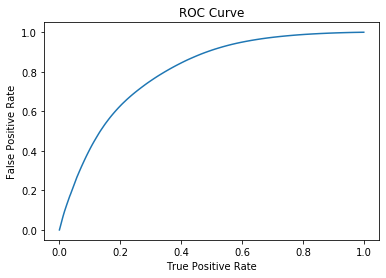

In [15]:
roc = train_Summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

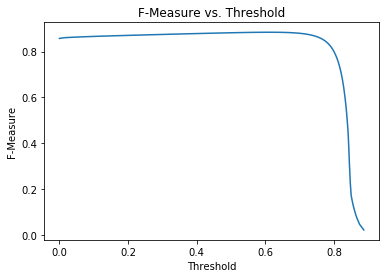

In [16]:
f = train_Summary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.title('F-Measure vs. Threshold')
plt.show()

In [17]:
### threshold
lr.getThreshold()

0.5

In [18]:
### Best f1 score to get threshold
fMeasure = train_Summary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
print('Best F1 score:', str(maxFMeasure[0]))
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)'])\
.select('threshold').head()['threshold']
print('Best threshold:',bestThreshold )

Best F1 score: 0.8842189489075295
Best threshold: 0.6145952841012762


In [19]:
### set new threshold
lr.setThreshold(bestThreshold)
lr.getThreshold()

0.6145952841012762

### Test on training data

In [20]:
### Predict using train
pred = lrModel.transform(train)

In [21]:
pred.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       1.0|[0.15834754065938...|
|  1.0|       1.0|[0.19629533382983...|
|  0.0|       1.0|[0.28521193673671...|
|  1.0|       1.0|[0.17577025381895...|
|  1.0|       1.0|[0.18867152156980...|
|  1.0|       1.0|[0.16409589457622...|
|  1.0|       1.0|[0.21761730013991...|
|  1.0|       1.0|[0.17040415682014...|
|  1.0|       1.0|[0.16566531771113...|
|  1.0|       1.0|[0.14367195980337...|
+-----+----------+--------------------+
only showing top 10 rows



### Evaluate Model

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [23]:
#### R0C
evaluator = BinaryClassificationEvaluator()
print('Train Area Under ROC', evaluator.evaluate(pred))

Train Area Under ROC 0.8000211819839322


In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
### can get the f1 score, accuracy, precision and recall using MulticlassClassificationEvaluator 

In [25]:
#### Accuracy 
acc = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
acc.evaluate(pred)

0.8036346612311925

In [26]:
#### F1 Score 
ff = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
ff.evaluate(pred)

0.7658305976991056

### Save model & pipeline 

In [27]:
### save pipeline 
pipelineFit.write().overwrite().save("pipline_train")

In [28]:
### save fitted model 
lrModel.save('LGmodel')